In [2]:
import os
import sys

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm


from ema_workbench.analysis import prim
from ema_workbench import ema_logging, load_results, MultiprocessingEvaluator
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

from problem_formulation import get_model_for_problem_formulation

In [25]:
problem_formulation_id = 7
dike_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = [u.name for u in dike_model.uncertainties]
levers = [l.name for l in dike_model.levers]
ooi = [o.name for o in dike_model.outcomes]
ooi_dr3 = ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'A.3_Dike Investment Costs']

In [21]:
experiment, outcomes = load_results(os.path.join('experiment', 'results_pol6_prb%d.tar.gz' % problem_formulation_id))
df_outcomes = pd.DataFrame(outcomes)

# General Analysis for OOI of Dike Ring 3
Goals
* Understand the OOI distribution
* Determine the thresholds for different OOI of Dike Ring 3

Steps
* Inspect the OOI distribution using: histogram and accumulative plots
* Identify threshold values for each OOI of Dike Ring 3

In [23]:
df_outcomes

,A.1_Dike Investment Costs,A.1_Expected Annual Damage,A.1_Expected Number of Deaths,A.2_Dike Investment Costs,A.2_Expected Annual Damage,A.2_Expected Number of Deaths,A.3_Dike Investment Costs,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,2.760434e+08,0.0,0.0,7.779711e+07,1.336352e+08,0.012321,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,6605.201655
1,2.760434e+08,0.0,0.0,7.779711e+07,4.372356e+07,0.003442,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,1728.294627
2,2.760434e+08,0.0,0.0,7.779711e+07,0.000000e+00,0.000000,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,0.000000
3,2.760434e+08,0.0,0.0,7.779711e+07,1.672455e+07,0.001300,0,0.0,0.0,4.417232e+07,5.761620e+04,0.000003,1.659631e+08,0.0,0.0,1.195400e+09,624.747288
4,2.760434e+08,0.0,0.0,7.779711e+07,0.000000e+00,0.000000,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.839277e+08,0.0,0.0,3.824512e+07,7.488377e+06,0.000560,24198032,0.0,0.0,3.018556e+07,7.764509e+05,0.000022,7.155554e+07,0.0,0.0,1.366900e+09,294.014571
596,1.839277e+08,0.0,0.0,3.824512e+07,0.000000e+00,0.000000,24198032,0.0,0.0,3.018556e+07,3.551073e+06,0.000171,7.155554e+07,0.0,0.0,1.366900e+09,226.222855
597,1.839277e+08,0.0,0.0,3.824512e+07,2.968074e+08,0.020150,24198032,0.0,0.0,3.018556e+07,0.000000e+00,0.000000,7.155554e+07,0.0,0.0,1.366900e+09,11084.668572
598,1.839277e+08,0.0,0.0,3.824512e+07,5.596359e+08,0.029641,24198032,0.0,0.0,3.018556e+07,4.127923e+07,0.000824,7.155554e+07,0.0,0.0,1.366900e+09,18300.107796


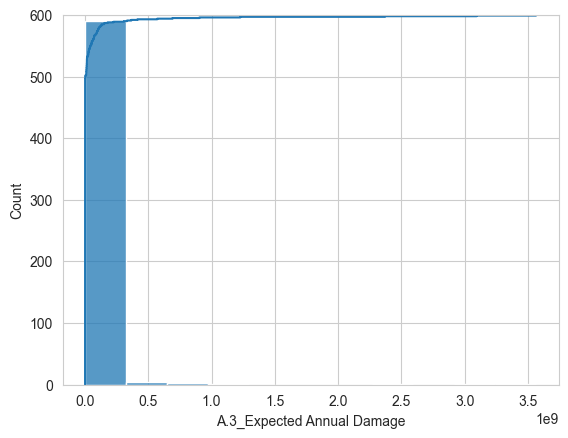

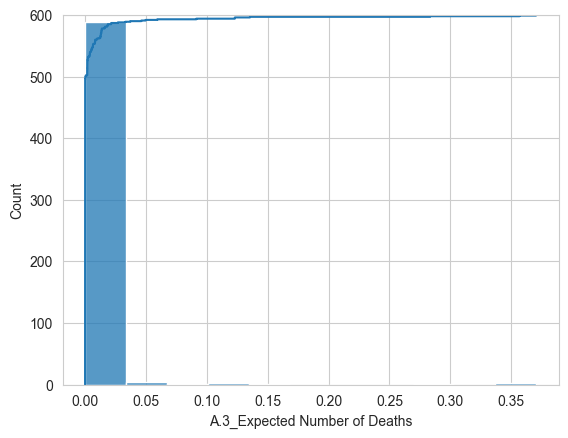

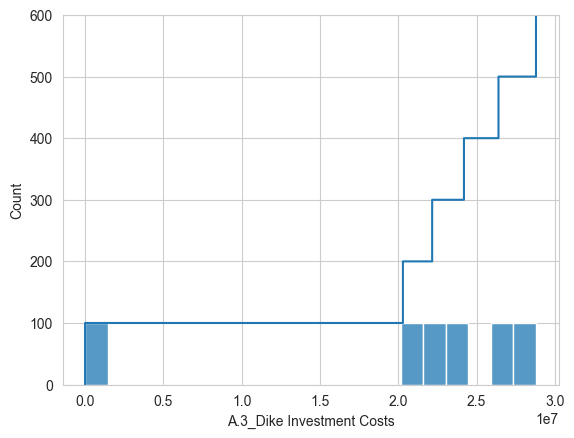

In [28]:
for o in ooi_dr3:
    sns.histplot(df_outcomes, x=o)
    sns.ecdfplot(df_outcomes, x=o, stat='count')
    plt.show()

In [29]:
df_outcomes[ooi_dr3].describe()

,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.3_Dike Investment Costs
count,6.000000e+02,600.000000,6.000000e+02
mean,3.062070e+07,0.003924,2.031115e+07
std,2.288629e+08,0.026193,9.496917e+06
min,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,2.029929e+07
50%,0.000000e+00,0.000000,2.318292e+07
75%,0.000000e+00,0.000000,2.640338e+07
max,3.563540e+09,0.370352,2.879840e+07


# Experiment without policies

In [30]:
experiment_0, outcomes_0 = load_results(os.path.join('experiment', 'results_pol0_prb%d.tar.gz' % problem_formulation_id))
df_outcomes_0 = pd.DataFrame(outcomes_0)

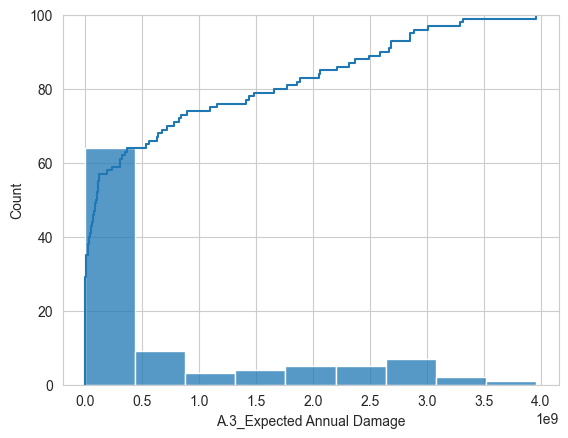

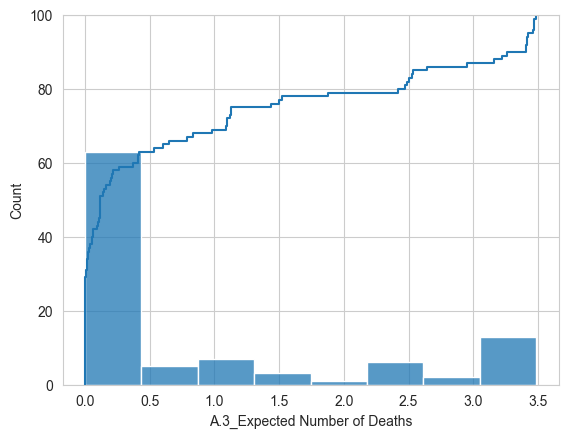

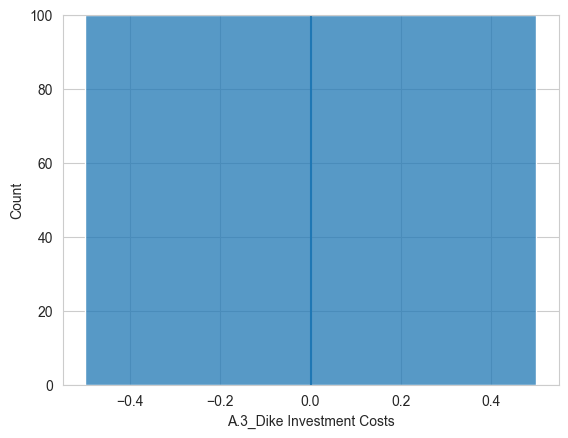

In [32]:
for o in ooi_dr3:
    sns.histplot(df_outcomes_0, x=o)
    sns.ecdfplot(df_outcomes_0, x=o, stat='count')
    plt.show()

In [33]:
df_outcomes_0[ooi_dr3].describe()

,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.3_Dike Investment Costs
count,1.000000e+02,100.000000,100.0
mean,7.096184e+08,0.865271,0.0
std,1.040643e+09,1.229727,0.0
min,0.000000e+00,0.000000,0.0
25%,0.000000e+00,0.000000,0.0
50%,1.007798e+08,0.114901,0.0
75%,1.112956e+09,1.204847,0.0
max,3.958337e+09,3.485154,0.0


In [46]:
experiment_0 = []
outcomes_0 = []
df_outcomes_0 = []
for i in range(5):
    experiment_, outcomes_ = load_results(os.path.join('experiment', 'results_pol0_prb%d_sd%d.tar.gz' % (problem_formulation_id, i)))
    
    experiment_.insert(experiment_.shape[1], 'seed', str(i))
    experiment_0.append(experiment_)
    
    outcomes_0.append(outcomes_)
    
    df_outcomes_ = pd.DataFrame(outcomes_)
    df_outcomes_.insert(df_outcomes_.shape[1], 'seed', str(i))
    df_outcomes_0.append(df_outcomes_)
    
experiment_0 = pd.concat(experiment_0, axis=0)
df_outcomes_0 = pd.concat(df_outcomes_0, axis=0)

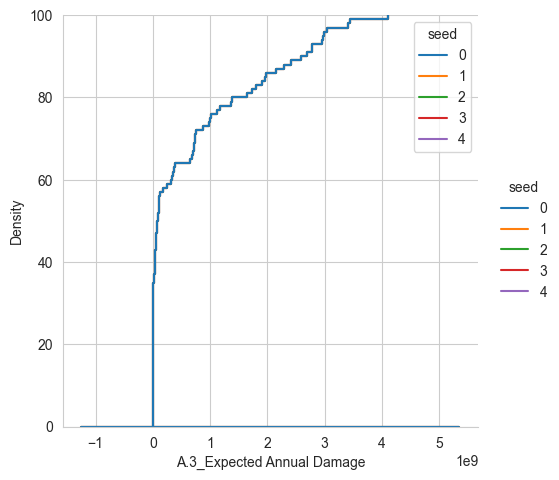

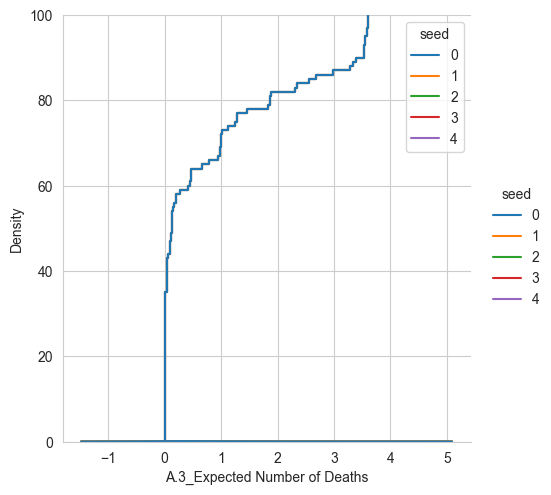

/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_12817/2164767250.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(df_outcomes_0, x=o, hue='seed', kind='kde')


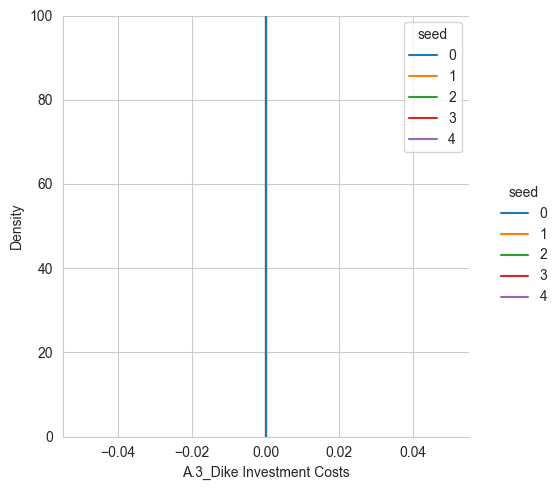

In [48]:
for o in ooi_dr3:
    sns.displot(df_outcomes_0, x=o, hue='seed', kind='kde')
    sns.ecdfplot(df_outcomes_0, x=o, hue='seed', stat='count')
    plt.show()

In [43]:
experiment_0.seed.value_counts()

seed
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64